### PROBLEM DEFINITION
If someone showed you a text of a person and asked you to guess what their personality is, chances are you’d have a pretty bad guess about it. What if your computer could do that?
What if it could become even better? It seems like an absurd thought, right?
A computer program is said to learn from experience E with respect to some class of tasks T and performance measure P,if its performance at tasks in T, as measured by P,improves with experience.




*   Task (T): Classify a particular person into the category of personality the person belongs to. [Classification]
*   Experience (E): Texts of different people,each person has up to 50 sentences.
*   Performance (P):Accurately perform work.






#### Importing Packages and Libraries

In [ ]:
# import tensorflow as tf
# tf.test.gpu_device_name()
import joblib

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns
import plotly.express as px

import sqlite3
from sqlite3 import Error

# Text Processing
import re
import itertools
import string
import collections
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline

### Database Creation and Extraction

#### Database Creation

In [ ]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):

    if drop_table_name: # You can optionally pass drop_table_name to drop the table.
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)

    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

def insert_table(conn, insert_table_sql, values):
    cur = conn.cursor()
    cur.executemany(insert_table_sql,values)

In [ ]:
types = []
posts = []
header = []
with open("mbti_1_1.csv", 'r',errors="ignore") as file:
    for line in file:
        type =  line.split(",",1)
        if not header:
            header.append(type[0])
            header.append(type[1])
        else:
            types.append(type[0])
            posts.append(type[1])
#     print(len(types))
#     print(types[:10])
#     print(posts[0])

In [ ]:
database_name = "project_database.db"

In [ ]:
types_values = []
for i in types:
    if i not in types_values:
        types_values.append(i)
types_values = tuple((i,) for i in types_values)
# print(types_values)

In [ ]:
conn = create_connection(database_name)
create_Types_table_query = """
        CREATE TABLE Types (
            type_id INTEGER NOT NULL PRIMARY KEY,
            type TEXT NOT NULL
        );
        """
with conn:
    create_table(conn, create_Types_table_query, "Types")
conn.close()

In [ ]:
conn = create_connection(database_name)
insert_Types_table_query = "INSERT INTO Types(type) VALUES(?)"
with conn:
    insert_table(conn,insert_Types_table_query, types_values)
conn.close()

In [ ]:
types_lookup = {}
conn = create_connection(database_name)
rows = execute_sql_statement("SELECT * FROM Types",conn)
for i in rows:
    types_lookup[i[1]] = i[0]
conn.close()
# print(types_lookup)

In [ ]:
person_type_values = []
for i in types:
    person_type_values.append(types_lookup[i])
person_type_values = tuple((i,) for i in person_type_values)
# print(person_type_values[:10])

In [ ]:
conn = create_connection(database_name)
create_Person_Type_table_query = """
        CREATE TABLE Person_Type (
            person_id INTEGER NOT NULL PRIMARY KEY,
            type_id INTEGER NOT NULL
        );
        """
with conn:
    create_table(conn, create_Person_Type_table_query, "Person_Type")
conn.close()

In [ ]:
conn = create_connection(database_name)
insert_Person_Type_table_query = "INSERT INTO Person_Type(type_id) VALUES(?)"
with conn:
    insert_table(conn,insert_Person_Type_table_query, person_type_values)
conn.close()

In [ ]:
person_type_lookup = {}
conn = create_connection(database_name)
rows = execute_sql_statement("SELECT * FROM Person_Type",conn)
for i in rows:
    person_type_lookup[i[0]] = i[1]
conn.close()

In [ ]:
posts_dict = {}
for i in range(len(posts)):
    posts[i] = posts[i].strip()
    # data.posts[i] = str(data.posts[i])[1:-1]
    if posts[i][0] == "'":
       posts[i] = posts[i][1:]
    if posts[i][-1] == "'":
        posts[i] = posts[i][:-1]
    temp = posts[i].split("|||")
    posts_dict[i+1] = temp

In [ ]:
posts_values = []
for key,value in posts_dict.items():
    for i in value:
        posts_values.append((key,i))
posts_values = tuple(posts_values)
# print(posts_values[:5])

In [ ]:
conn = create_connection(database_name)
create_Posts_table_query = """
        CREATE TABLE Posts (
            post_id INTEGER NOT NULL PRIMARY KEY,
            person_id INTEGER NOT NULL,
            post TEXT NOT NULL,
            FOREIGN KEY(person_id) REFERENCES Person_Type(person_id)
        );
        """
with conn:
    create_table(conn, create_Posts_table_query, "Posts")
conn.close()

In [ ]:
conn = create_connection(database_name)
insert_Posts_table_query = "INSERT INTO Posts(person_id, post) VALUES(?,?)"
with conn:
    insert_table(conn,insert_Posts_table_query, posts_values)
conn.close()

#### Pulling data from dataset

In [ ]:
conn = create_connection(database_name)
sql_query="""
Select t1.person_id,t1.post,t3.type,substr(t3.type,1,1) as Type_1,substr(t3.type,2,1) as Type_2,substr(t3.type,3,1) as Type_3,substr(t3.type,4,1) as Type_4
from posts t1
left join Person_Type t2 on t1.person_id=t2.person_id
left join Types t3 on t2.type_id=t3.type_id
"""
df = pd.read_sql_query(sql_query,conn)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141087 entries, 0 to 141086
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   person_id  141087 non-null  int64 
 1   post       141087 non-null  object
 2   type       141087 non-null  object
 3   Type_1     141087 non-null  object
 4   Type_2     141087 non-null  object
 5   Type_3     141087 non-null  object
 6   Type_4     141087 non-null  object
dtypes: int64(1), object(6)
memory usage: 7.5+ MB


### Data Analysis, EDA and Preprocessing

#### EDA

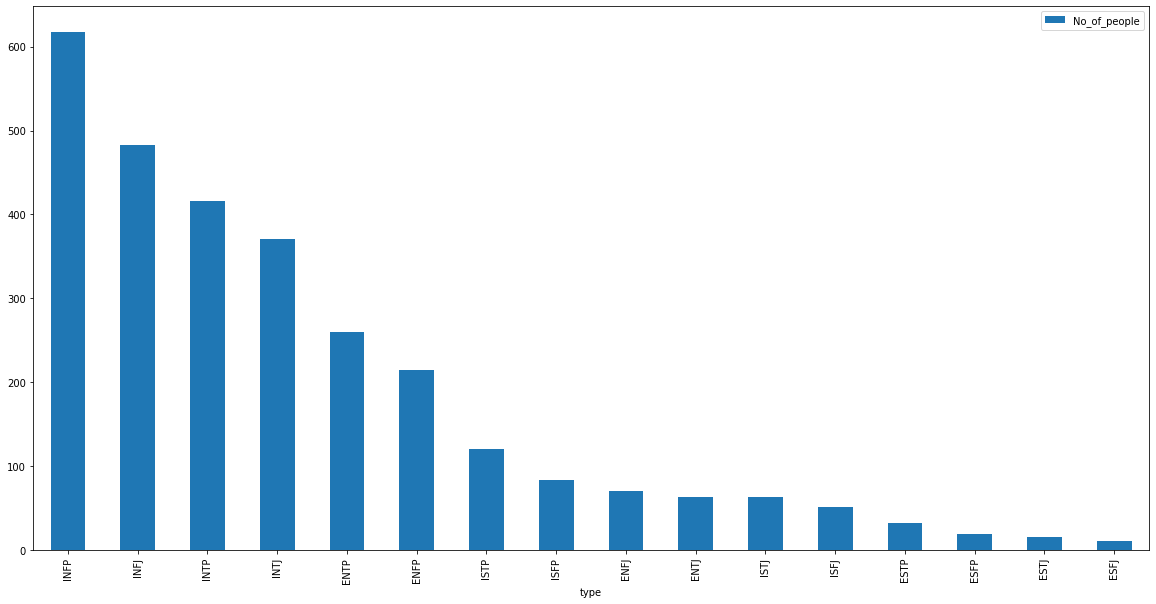

In [ ]:
conn = create_connection(database_name)
sql_query="""
Select t3.type, count(distinct t2.person_id) as No_of_people
from posts t1
left join Person_Type t2 on t1.person_id=t2.person_id
left join Types t3 on t2.type_id=t3.type_id
group by t3.type
order by count(distinct t2.person_id) desc
"""
d_1=pd.read_sql_query(sql_query,conn)
d_1.plot(kind='bar',x='type', figsize = (20,10))

In [ ]:
conn = create_connection(database_name)
sql_query="""
Select t2.person_id, count(distinct t1.post_id) as No_of_posts
from posts t1
left join Person_Type t2 on t1.person_id=t2.person_id
left join Types t3 on t2.type_id=t3.type_id
group by t2.person_id
"""
d_1=pd.read_sql_query(sql_query,conn)
d_1.head()

,person_id,No_of_posts
0,1,50
1,2,50
2,3,50
3,4,50
4,5,50


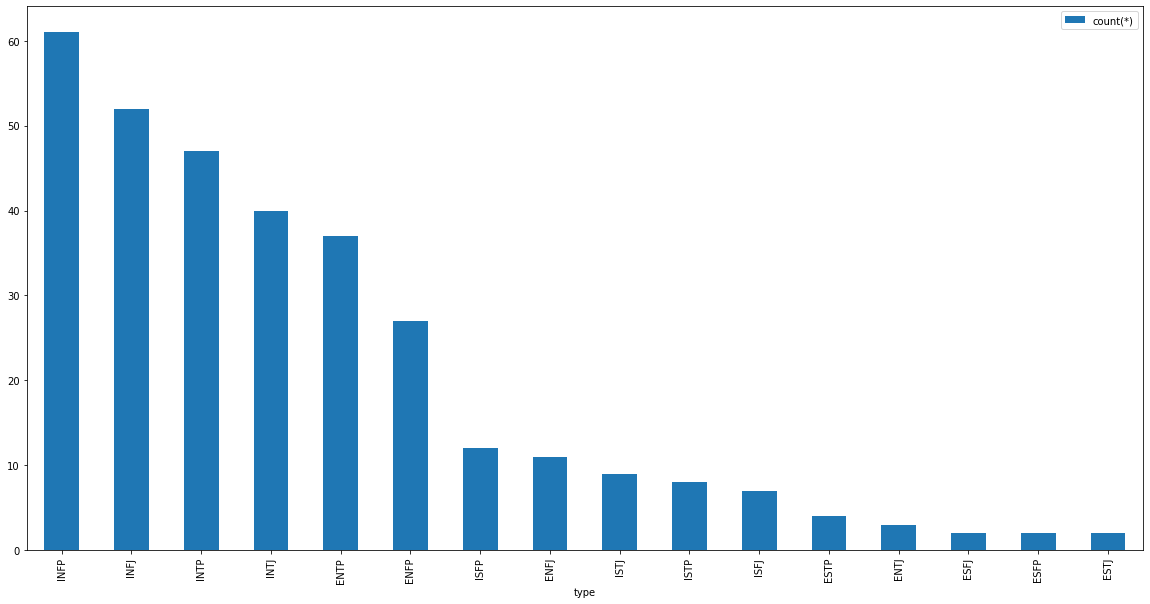

In [ ]:
conn = create_connection(database_name)
sql_query="""
select type,count(*)
from
(Select t2.person_id, count(distinct t1.post_id) as No_of_posts
from posts t1
left join Person_Type t2 on t1.person_id=t2.person_id
group by t2.person_id) t4
left join Person_Type t5 on t5.person_id=t4.person_id
left join Types t6 on t5.type_id=t6.type_id
where No_of_posts<50
group by type
order by count(*) desc

"""
d_1=pd.read_sql_query(sql_query,conn)
d_1.plot(kind='bar',x='type', figsize = (20,10))

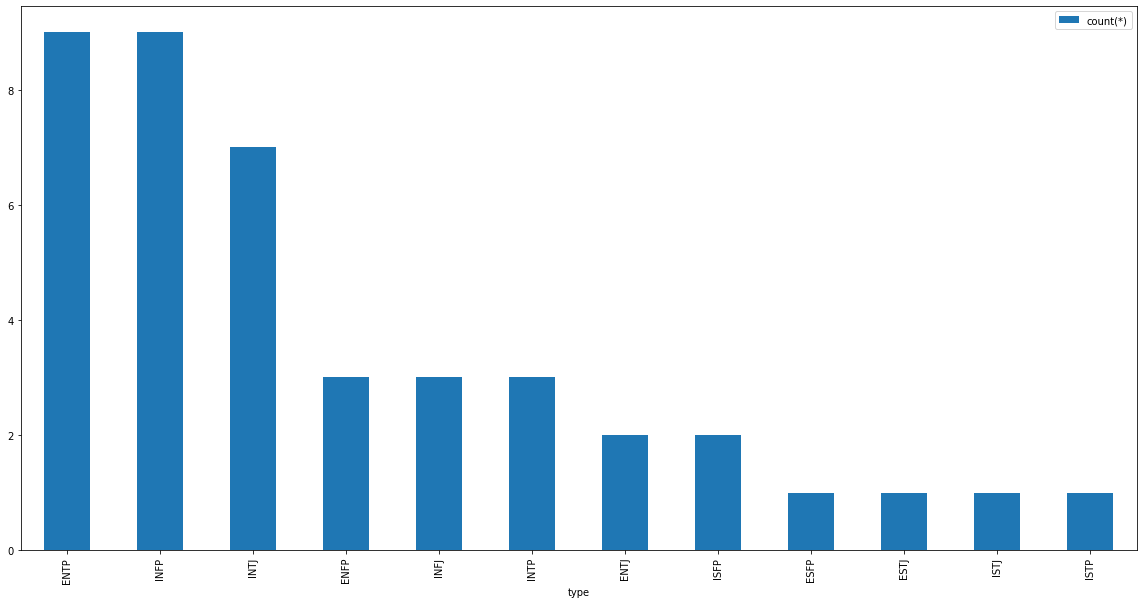

In [ ]:
conn = create_connection(database_name)
sql_query="""
select type,count(*)
from
(Select t2.person_id, count(distinct t1.post_id) as No_of_posts
from posts t1
left join Person_Type t2 on t1.person_id=t2.person_id
group by t2.person_id) t4
left join Person_Type t5 on t5.person_id=t4.person_id
left join Types t6 on t5.type_id=t6.type_id
where No_of_posts>50
group by type
order by count(*) desc

"""
d_1=pd.read_sql_query(sql_query,conn)
d_1.plot(kind='bar',x='type', figsize = (20,10))

In [ ]:
conn = create_connection(database_name)
sql_query="""
Select post,t1.person_id,type
from posts t1
left join Person_Type t2 on t1.person_id=t2.person_id
left join Types t3 on t2.type_id=t3.type_id
where t1.post not like "%http://%"
group by t3.type
order by count(*) desc
"""
df_link = pd.read_sql_query(sql_query,conn)
df_link

,post,person_id,type
0,"Virility, without a doubt.'""",2885,INFP
1,Whenever I order a pizza I really want to give...,2883,INFJ
2,I think I'm an INTP (but my friend thinks I'm ...,2884,INTP
3,Professionally? No. But if I am invited to a w...,2888,INTJ
4,Get away from him immediately. If you think of...,2881,ENTP
5,"Commitment must transcend interest, otherwise ...",2886,ENFP
6,"Got beat up alot'""",2889,ISTP
7,I am engaged to a very sweet and wonderful INF...,2890,ISFP
8,By Your Side ~ Sade,2863,ENFJ
9,"During important moments in my life, poetry co...",2759,ENTJ


In [ ]:
df_link['post'][0]

'Virility, without a doubt.\'"'

#### Analyzing texts

In [ ]:
words = list(df['post'].apply(lambda x: x.split()))
words = [x for y in words for x in y]

words_link = list(df_link['post'].apply(lambda x: x.split()))
words_link = [x for y in words_link for x in y]
print('unique words in whole dataset',len(words),'\nunique words in https dataset',len(words_link),'\nunique words in without counting links',len(words)-len(words_link))
# Counter(words)

unique words in whole dataset 3683058 
unique words in https dataset 365 
unique words in without counting links 3682693


In [ ]:
Counter(words).most_common(10)

[('I', 153963),
 ('to', 97113),
 ('the', 91235),
 ('a', 76638),
 ('and', 73525),
 ('of', 59299),
 ('you', 43812),
 ('is', 42894),
 ('that', 42600),
 ('in', 39112)]

#### Removing links and punctuations

In [ ]:
df_cpy=df.copy()

In [ ]:
def f(x):
    for i in x:
        if i.isalpha() or i.isspace():
            pass
        else:
            x = x.replace(i,"")
    return x

In [ ]:
df_cpy['post'] = df_cpy['post'].apply(lambda x: re.sub(r'http\S+', '', x))
df_cpy['post'] = df_cpy['post'].apply(f)
df_cpy['post'] = df_cpy['post'].apply(lambda x: x.lower())


In [ ]:
df_cpy.head()

,person_id,post,type,Type_1,Type_2,Type_3,Type_4
0,1,,INFJ,I,N,F,J
1,1,,INFJ,I,N,F,J
2,1,enfp and intj moments sportscenter not top ...,INFJ,I,N,F,J
3,1,what has been the most lifechanging experience...,INFJ,I,N,F,J
4,1,on repeat for most of today,INFJ,I,N,F,J


In [ ]:
words = list(df_cpy['post'].apply(lambda x: x.split()))
words = [x for y in words for x in y]

In [ ]:
Counter(words).most_common(10)

[('i', 168102),
 ('the', 103766),
 ('to', 101880),
 ('a', 81463),
 ('and', 81113),
 ('of', 61904),
 ('you', 55866),
 ('that', 49620),
 ('it', 46984),
 ('is', 46657)]

In [ ]:
df_lk_rem=df_cpy[df_cpy['post']!='']

In [ ]:
df_lk_rem['words_cnt']=df_lk_rem['post'].apply(lambda x: len(x.split()))

<ipython-input-33-1b9f51fcb059>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lk_rem['words_cnt']=df_lk_rem['post'].apply(lambda x: len(x.split()))


In [ ]:
df_lk_rem.head()

,person_id,post,type,Type_1,Type_2,Type_3,Type_4,words_cnt
2,1,enfp and intj moments sportscenter not top ...,INFJ,I,N,F,J,10
3,1,what has been the most lifechanging experience...,INFJ,I,N,F,J,10
4,1,on repeat for most of today,INFJ,I,N,F,J,6
5,1,may the perc experience immerse you,INFJ,I,N,F,J,6
6,1,the last thing my infj friend posted on his fa...,INFJ,I,N,F,J,19


In [ ]:
df_lk_rem.describe()

,person_id,words_cnt
count,136922.000000,136922.000000
mean,1445.117286,26.460160
std,834.138488,12.579328
min,1.000000,0.000000
25%,720.000000,15.000000
50%,1445.000000,32.000000
75%,2167.000000,37.000000
max,2890.000000,50.000000


In [ ]:
fig1 = px.box(df_lk_rem, y="words_cnt", boxmode="overlay")
fig1.show()

In [ ]:
fig1 = px.box(df_lk_rem[df_lk_rem['words_cnt']>=36], y="words_cnt", boxmode="overlay")
fig1.show()

#### Removing the outliers based on word count

In [ ]:
new_df=df_lk_rem[df_lk_rem['words_cnt']<=42]

#### Feature Engineering

In [ ]:
enc = LabelEncoder()
new_df['encoder_t1']=enc.fit_transform(new_df['Type_1'])
new_df['encoder_t2']=enc.fit_transform(new_df['Type_2'])
new_df['encoder_t3']=enc.fit_transform(new_df['Type_3'])
new_df['encoder_t4']=enc.fit_transform(new_df['Type_4'])

<ipython-input-39-15fef5df2499>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-39-15fef5df2499>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-39-15fef5df2499>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-39-15fef5d

In [ ]:
new_df['encoder_t1'].drop_duplicates()

2     1
50    0
Name: encoder_t1, dtype: int64

We will be droppingthe stop words to reduce the load on the model

In [ ]:
vect = CountVectorizer(stop_words='english')
train =  vect.fit_transform(new_df["post"])

### Model creation and evaluation

In [ ]:
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [ ]:
target_1=new_df['Type_1']
target_2=new_df['Type_2']
target_3=new_df['Type_3']
target_4=new_df['Type_4']

#### Train and Test split based on Stratified sampling

In [ ]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(train, target_1, test_size=0.4, stratify=target_1, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(train, target_2, test_size=0.4, stratify=target_2, random_state=42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(train, target_3, test_size=0.4, stratify=target_3, random_state=42)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(train, target_3, test_size=0.4, stratify=target_4, random_state=42)

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train_4, y_train_4)

RandomForestClassifier()

In [ ]:
joblib.dump(random_forest, "random_forest.joblib")

['random_forest.joblib']

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
Y_pred_4 = random_forest.predict(X_test_4)

predictions_4 = [(value) for value in Y_pred_4]

# Model evaluation
accuracy = accuracy_score(y_test_4, predictions_4)
# accuracies_1['Random Forest'] = accuracy* 100.0

print("Accuracy of Type_4: %.2f%%" % (accuracy * 100.0))

Accuracy of Type_4: 59.87%


In [ ]:
Y_train_4 = random_forest.predict(X_train_4)

tr_predictions_4 = [(value) for value in Y_train_4]

accuracy = accuracy_score(y_train_4, tr_predictions_4)
# accuracies_1['Random Forest'] = accuracy* 100.0

print("Train Accuracy of Type_4: %.2f%%" % (accuracy * 100.0))

NameError: ignored

#### XG Boost

In [ ]:
#XG boost Classifier
xgb = XGBClassifier()
xgb.fit(X_train_4,y_train_4)

Y_pred = xgb.predict(X_test_4)
predictions = [(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test_4, predictions)
# accuracies['XG Boost'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 57.52%


In [ ]:
joblib.dump(xgb, "xgb.joblib")

['xgb.joblib']

#### Gradient Descent

In [ ]:
#Gradient Descent
sgd = SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train_4, y_train_4)

Y_pred_4 = sgd.predict(X_test_4)
predictions = [(value) for value in Y_pred_4]

# evaluate predictions
accuracy = accuracy_score(y_test_4, predictions)
# accuracies['Gradient Descent'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 59.83%


In [ ]:
joblib.dump(sgd, "sgd.joblib")

['sgd.joblib']

#### Logistic Regression

In [ ]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train_4, y_train_4)

Y_pred = logreg.predict(X_test_4)
predictions = [(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test_4, predictions)
# accuracies['Logistic Regression'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 60.16%


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
joblib.dump(logreg, "logreg.joblib")

['logreg.joblib']

#### KNN Classifier

In [ ]:
#KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 2)  # n_neighbors means k
knn.fit(X_train_4, y_train_4)

Y_pred = knn.predict(X_test_4)
predictions = [(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test_4, predictions)
# accuracies['KNN'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 53.78%


In [ ]:
joblib.dump(knn, "knn.joblib")

['knn.joblib']

#### SVC

In [ ]:
from sklearn.svm import SVC
svm = SVC(random_state = 1)
svm.fit(X_train_4, y_train_4)

Y_pred = svm.predict(X_test_4)

predictions = [(value) for value in Y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test_4, predictions)
# accuracies['SVM'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 61.19%


In [ ]:
joblib.dump(svm, "svm.joblib")

['svm.joblib']

### Loading Trained Models

In [ ]:
#Loading Type 1 models
# loaded_rf_1 = joblib.load("random_forest_1.joblib")
loaded_knn_1 = joblib.load("knn_1.joblib")
loaded_logreg_1 = joblib.load("logreg_1.joblib")
loaded_sgd_1 = joblib.load("sgd_1.joblib")
loaded_svm_1 = joblib.load("svm_1.joblib")
loaded_xgd_1 = joblib.load("logreg_1.joblib")


In [ ]:
#Loading Type 3 models
# loaded_rf_2 = joblib.load("random_forest_2.joblib")
loaded_knn_2 = joblib.load("knn_2.joblib")
loaded_logreg_2 = joblib.load("logreg_2.joblib")
loaded_sgd_2 = joblib.load("sgd_2.joblib")
loaded_svm_2 = joblib.load("svm_2.joblib")
loaded_xgd_2 = joblib.load("logreg_2.joblib")


In [ ]:
#Loading Type 3 models
# loaded_rf_3 = joblib.load("random_forest_3.joblib")
loaded_knn_3 = joblib.load("knn_3.joblib")
loaded_logreg_3 = joblib.load("logreg_3.joblib")
loaded_sgd_3 = joblib.load("sgd_3.joblib")
loaded_svm_3 = joblib.load("svm_3.joblib")
loaded_xgd_3 = joblib.load("logreg_3.joblib")


In [ ]:
#Loading Type 4 models
# loaded_rf_4 = joblib.load("random_forest_4.joblib")
loaded_knn_4 = joblib.load("knn_4.joblib")
loaded_logreg_4 = joblib.load("logreg_4.joblib")
loaded_sgd_4 = joblib.load("sgd_4.joblib")
loaded_svm_4 = joblib.load("svm_4.joblib")
loaded_xgd_4 = joblib.load("logreg_4.joblib")


### Results:



1.   We observed that Support vector classifier produced best accuracy for all types. The disadvantage of SVC was that it took a long time to train the model, hence scaling it for the whole dataset will be challenging
2.   Gradient Boost too had good accuracy, and training time was considerable less than the SVC



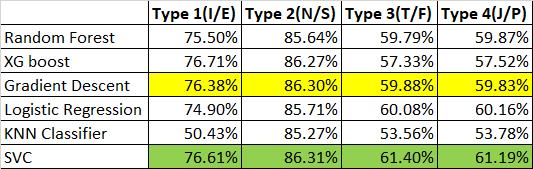